tiny dataset으로 biasing test

###모델이 해당 객체를 보고 판단하는지 scene bais를 보고 판단하는지 실험해보자

tiny dataset 에는 bounding box에 대한 label 이 있는데 이를 이용하여 그냥 dataset으로 학습한 모델을 bounding box를 black 처리한 이미지를 test해보면서 성능차이를 비교 해보자~



In [ ]:
import torchvision.models as models
from google.colab import drive
drive.mount('/content/drive')
!mkdir ./dataset
!unzip  -qq /content/drive/MyDrive/tiny-imagenet-200.zip -d ./dataset



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## https://colab.research.google.com/drive/1HWfA_JrjoehfZ1zP60MWKo85fBeKccRg?usp=sharing#scrollTo=aFLB8yn7NIBy

In [ ]:
# Install Python packages
!pip install numpy torch torchvision pytorch-ignite tensorboardX tensorboard opendatasets efficientnet-pytorch

     |████████████████████████████████| 232 kB 5.4 MB/s 
     |████████████████████████████████| 124 kB 50.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=6a96f0e4f1e26eb5b99b3baa30c6cd1fcb06bb2c31692e98dbb1016dc1553479
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

import torch
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision import models, datasets
from torchvision import transforms as T

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, Precision, Recall
from ignite.handlers import LRScheduler, ModelCheckpoint, global_step_from_engine
from ignite.contrib.handlers import ProgressBar, TensorboardLogger
import ignite.contrib.engines.common as common

import opendatasets as od
import os
from random import randint
import urllib
import zipfile

# Define device to use (CPU or GPU). CUDA = GPU support for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
DATA_DIR = '/content/dataset/tiny-imagenet-200' # Original images come in shapes of [3,64,64]

# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')

In [ ]:
# Functions to display single or a batch of sample images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def show_batch(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()    
    imshow(make_grid(images)) # Using Torchvision.utils make_grid function
    
def show_image(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()
    random_num = randint(0, len(images)-1)
    imshow(images[random_num])
    label = labels[random_num]
    print(f'Label: {label}, Shape: {images[random_num].shape}')

# Setup function to create dataloaders for image datasets
def generate_dataloader(data, name, transform):
    if data is None: 
        return None
    
    # Read image files to pytorch dataset using ImageFolder, a generic data 
    # loader where images are in format root/label/filename
    # See https://pytorch.org/vision/stable/datasets.html
    if transform is None:
        dataset = datasets.ImageFolder(data, transform=T.ToTensor())
    else:
        dataset = datasets.ImageFolder(data, transform=transform)

    # Set options for device
    if use_cuda:
        kwargs = {"pin_memory": True, "num_workers": 1}
    else:
        kwargs = {}
    
    # Wrap image dataset (defined above) in dataloader 
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                        shuffle=(name=="train"), 
                        **kwargs)
    
    return dataloader

In [ ]:
# Unlike training folder where images are already arranged in sub folders based 
# on their labels, images in validation folder are all inside a single folder. 
# Validation folder comes with images folder and val_annotations txt file. 
# The val_annotation txt file comprises 6 tab separated columns of filename, 
# class label, x and y coordinates, height, and width of bounding boxes
val_data = pd.read_csv(f'{VALID_DIR}/val_annotations.txt', 
                       sep='\t', 
                       header=None, 
                       names=['File', 'Class', 'X', 'Y', 'H', 'W'])

val_data.head(150)

,File,Class,X,Y,H,W
0,val_0.JPEG,n03444034,0,32,44,62
1,val_1.JPEG,n04067472,52,55,57,59
2,val_2.JPEG,n04070727,4,0,60,55
3,val_3.JPEG,n02808440,3,3,63,63
4,val_4.JPEG,n02808440,9,27,63,48
...,...,...,...,...,...,...
145,val_145.JPEG,n04008634,25,5,50,62
146,val_146.JPEG,n07615774,43,8,48,11
147,val_147.JPEG,n03837869,5,0,33,63
148,val_148.JPEG,n04371430,19,22,40,35


## bounding box에 mask 만들기

In [ ]:
VALID_DIR

'/content/dataset/tiny-imagenet-200/val'

In [ ]:
# image에 mask 씌우기
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
dataset = ImageFolder(root=VALID_DIR, transform=T.ToTensor())

for i in range(10000):
  img=dataset.__getitem__(i)[0]
  position = val_data.loc[val_data["File"] == dataset.imgs[i][0].split('/')[-1]].values[0][2:]
  x,y,max_x,max_y = position
  temp = img.clone()
  temp[:,y:max_y,x:max_x] = 0
  masked_path = dataset.imgs[i][0].replace("images", "masked_images")
  if not(os.path.isdir(masked_path.rsplit('/',1)[0])):
      os.mkdir(masked_path.rsplit('/',1)[0])
  save_image(temp,masked_path)


In [ ]:
# Save class names (for corresponding labels) as dict from words.txt file
class_to_name_dict = dict()
fp = open(os.path.join(DATA_DIR, 'words.txt'), 'r')
data = fp.readlines()
for line in data:
    words = line.strip('\n').split('\t')
    class_to_name_dict[words[0]] = words[1].split(',')[0]
fp.close()

# Display first 20 entries of resulting dictionary
{k: class_to_name_dict[k] for k in list(class_to_name_dict)[:20]}

{'n00001740': 'entity',
 'n00001930': 'physical entity',
 'n00002137': 'abstraction',
 'n00002452': 'thing',
 'n00002684': 'object',
 'n00003553': 'whole',
 'n00003993': 'congener',
 'n00004258': 'living thing',
 'n00004475': 'organism',
 'n00005787': 'benthos',
 'n00005930': 'dwarf',
 'n00006024': 'heterotroph',
 'n00006150': 'parent',
 'n00006269': 'life',
 'n00006400': 'biont',
 'n00006484': 'cell',
 'n00007347': 'causal agent',
 'n00007846': 'person',
 'n00015388': 'animal',
 'n00017222': 'plant'}

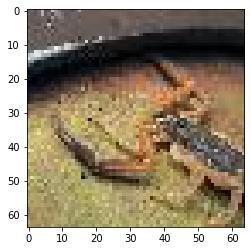

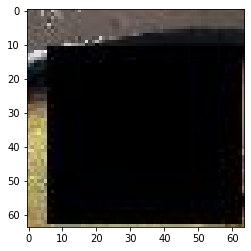

scorpion


In [ ]:
import matplotlib.pyplot as plt

index = 4586

dataset = ImageFolder(root=VALID_DIR, transform=T.ToTensor())
label = val_data.loc[val_data["File"] == dataset.imgs[index][0].split('/')[-1]].values[0][1]
img = dataset.__getitem__(index)[0]
masked_img = dataset.__getitem__(index+10000)[0]
img = img.numpy() 
plt.imshow(np.transpose(img, (1, 2, 0))) 
plt.show()
plt.imshow(np.transpose(masked_img, (1, 2, 0))) 
plt.show()
print(class_to_name_dict[label])

In [ ]:
val_img_dict

{'val_0.JPEG': 'n03444034',
 'val_1.JPEG': 'n04067472',
 'val_2.JPEG': 'n04070727',
 'val_3.JPEG': 'n02808440',
 'val_4.JPEG': 'n02808440',
 'val_5.JPEG': 'n04399382',
 'val_6.JPEG': 'n04179913',
 'val_7.JPEG': 'n02823428',
 'val_8.JPEG': 'n04146614',
 'val_9.JPEG': 'n02226429',
 'val_10.JPEG': 'n04371430',
 'val_11.JPEG': 'n07753592',
 'val_12.JPEG': 'n02226429',
 'val_13.JPEG': 'n03770439',
 'val_14.JPEG': 'n02056570',
 'val_15.JPEG': 'n02906734',
 'val_16.JPEG': 'n02125311',
 'val_17.JPEG': 'n04486054',
 'val_18.JPEG': 'n04285008',
 'val_19.JPEG': 'n03763968',
 'val_20.JPEG': 'n03814639',
 'val_21.JPEG': 'n03837869',
 'val_22.JPEG': 'n01983481',
 'val_23.JPEG': 'n01629819',
 'val_24.JPEG': 'n04532670',
 'val_25.JPEG': 'n04074963',
 'val_26.JPEG': 'n04540053',
 'val_27.JPEG': 'n04371430',
 'val_28.JPEG': 'n02906734',
 'val_29.JPEG': 'n02094433',
 'val_30.JPEG': 'n03796401',
 'val_31.JPEG': 'n07614500',
 'val_32.JPEG': 'n03837869',
 'val_33.JPEG': 'n03937543',
 'val_34.JPEG': 'n065963

In [ ]:
# Create separate validation subfolders for the validation images based on
# their labels indicated in the val_annotations txt file
val_img_dir = os.path.join(VALID_DIR, 'images')

# Open and read val annotations text file
fp = open(os.path.join(VALID_DIR, 'val_annotations.txt'), 'r')
data = fp.readlines()

# Create dictionary to store img filename (word 0) and corresponding
# label (word 1) for every line in the txt file (as key value pair)
val_img_dict = {}
for line in data:
    words = line.split('\t')
    val_img_dict[words[0]] = words[1]
fp.close()

# Display first 10 entries of resulting val_img_dict dictionary
{k: val_img_dict[k] for k in list(val_img_dict)[:10]}

{'val_0.JPEG': 'n03444034',
 'val_1.JPEG': 'n04067472',
 'val_2.JPEG': 'n04070727',
 'val_3.JPEG': 'n02808440',
 'val_4.JPEG': 'n02808440',
 'val_5.JPEG': 'n04399382',
 'val_6.JPEG': 'n04179913',
 'val_7.JPEG': 'n02823428',
 'val_8.JPEG': 'n04146614',
 'val_9.JPEG': 'n02226429'}

In [ ]:
# Create subfolders (if not present) for validation images based on label ,
# and move images into the respective folders
for img, folder in val_img_dict.items():
    newpath = (os.path.join(val_img_dir, folder))
    print(newpath)
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if os.path.exists(os.path.join(val_img_dir, img)):
        os.rename(os.path.join(val_img_dir, img), os.path.join(newpath, img))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/content/dataset/tiny-imagenet-200/val/images/n02074367
/content/dataset/tiny-imagenet-200/val/images/n03977966
/content/dataset/tiny-imagenet-200/val/images/n03424325
/content/dataset/tiny-imagenet-200/val/images/n02236044
/content/dataset/tiny-imagenet-200/val/images/n01882714
/content/dataset/tiny-imagenet-200/val/images/n07711569
/content/dataset/tiny-imagenet-200/val/images/n03160309
/content/dataset/tiny-imagenet-200/val/images/n03544143
/content/dataset/tiny-imagenet-200/val/images/n01882714
/content/dataset/tiny-imagenet-200/val/images/n02909870
/content/dataset/tiny-imagenet-200/val/images/n02226429
/content/dataset/tiny-imagenet-200/val/images/n03085013
/content/dataset/tiny-imagenet-200/val/images/n02909870
/content/dataset/tiny-imagenet-200/val/images/n02808440
/content/dataset/tiny-imagenet-200/val/images/n01984695
/content/dataset/tiny-imagenet-200/val/images/n03983396
/content/dataset/tiny-imagenet-200/val/images/n01917289
/content/dat

In [ ]:
# Create subfolders (if not present) for validation images based on label ,
# and move images into the respective folders
val_masked_img_dir = val_img_dir.replace('images','masked_images')
for img, folder in val_img_dict.items():
    newpath = (os.path.join(val_masked_img_dir, folder))
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if os.path.exists(os.path.join(val_masked_img_dir, img)):
        os.rename(os.path.join(val_masked_img_dir, img), os.path.join(newpath, img))

In [ ]:
val_img_dir

'/content/dataset/tiny-imagenet-200/val/images'

In [ ]:
val_img_dict.items()

dict_items([('val_0.JPEG', 'n03444034'), ('val_1.JPEG', 'n04067472'), ('val_2.JPEG', 'n04070727'), ('val_3.JPEG', 'n02808440'), ('val_4.JPEG', 'n02808440'), ('val_5.JPEG', 'n04399382'), ('val_6.JPEG', 'n04179913'), ('val_7.JPEG', 'n02823428'), ('val_8.JPEG', 'n04146614'), ('val_9.JPEG', 'n02226429'), ('val_10.JPEG', 'n04371430'), ('val_11.JPEG', 'n07753592'), ('val_12.JPEG', 'n02226429'), ('val_13.JPEG', 'n03770439'), ('val_14.JPEG', 'n02056570'), ('val_15.JPEG', 'n02906734'), ('val_16.JPEG', 'n02125311'), ('val_17.JPEG', 'n04486054'), ('val_18.JPEG', 'n04285008'), ('val_19.JPEG', 'n03763968'), ('val_20.JPEG', 'n03814639'), ('val_21.JPEG', 'n03837869'), ('val_22.JPEG', 'n01983481'), ('val_23.JPEG', 'n01629819'), ('val_24.JPEG', 'n04532670'), ('val_25.JPEG', 'n04074963'), ('val_26.JPEG', 'n04540053'), ('val_27.JPEG', 'n04371430'), ('val_28.JPEG', 'n02906734'), ('val_29.JPEG', 'n02094433'), ('val_30.JPEG', 'n03796401'), ('val_31.JPEG', 'n07614500'), ('val_32.JPEG', 'n03837869'), ('val_33

In [ ]:
# Define transformation sequence for image pre-processing
# If not using pre-trained model, normalize with 0.5, 0.5, 0.5 (mean and SD)
# If using pre-trained ImageNet, normalize with mean=[0.485, 0.456, 0.406], 
# std=[0.229, 0.224, 0.225])
preprocess_transform = T.Compose([
                T.Resize(64), # Resize images to 256 x 256
                # T.CenterCrop(224), # Center crop image
                T.RandomHorizontalFlip(),
                T.ToTensor(),  # Converting cropped images to tensors
                T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # 
])

preprocess_transform_pretrain = T.Compose([
                T.Resize(64), # Resize images to 256 x 256
                # T.CenterCrop(224), # Center crop image
                T.RandomHorizontalFlip(),
                T.ToTensor(),  # Converting cropped images to tensors
                T.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
])

In [ ]:
# Define batch size for data loaders
batch_size = 64

train_loader = generate_dataloader(TRAIN_DIR, "train",
                                  transform=preprocess_transform)

In [ ]:
# Create train loader for pre-trained models (normalized based on specific requirements)
train_loader_pretrain = generate_dataloader(TRAIN_DIR, "train",
                                  transform=preprocess_transform_pretrain)

In [ ]:
batch_size = 64

# Create dataloaders for validation data (depending if model is pretrained)
val_loader = generate_dataloader(val_img_dir, "val",
                                 transform=preprocess_transform)

val_loader_pretrain = generate_dataloader(val_img_dir, "val",
                                 transform=preprocess_transform_pretrain)


masked_val_loader_pretrain = generate_dataloader(val_masked_img_dir, "val",
                                 transform=preprocess_transform_pretrain)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


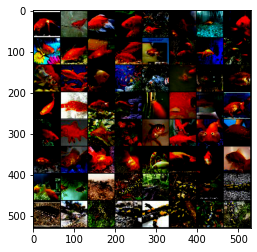

In [ ]:
# Display batch of validation images
show_batch(val_loader)

In [ ]:
# Define model architecture (using efficientnet-b3 version)
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=200)
model = model.to(device)

# Move model to designated 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()
n_epochs = 8
print_every = 300
valid_loss_min = np.Inf
val_loss = []
val_acc = []
masked_val_loss = []
masked_val_acc = []


train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader_pretrain):
        data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % print_every == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')

    # valid
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (val_loader_pretrain):
            data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(val_loader_pretrain))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
    if network_learned:
      valid_loss_min = batch_loss
      torch.save(model.state_dict(), 'model_classification_tutorial.pt')
      print('Detected network improvement, saving current model')
      
    #masked valid
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
      model.eval()
      for data_t, target_t in (masked_val_loader_pretrain):
          data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
          outputs_t = model(data_t)
          loss_t = criterion(outputs_t, target_t)
          batch_loss += loss_t.item()
          _,pred_t = torch.max(outputs_t, dim=1)
          correct_t += torch.sum(pred_t==target_t).item()
          total_t += target_t.size(0)
      masked_val_acc.append(100 * correct_t / total_t)
      masked_val_loss.append(batch_loss/len(masked_val_loader_pretrain))
      print(f'masked_validation loss: {np.mean(masked_val_loss):.4f}, masked_validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight 
 
    model.train()

Loaded pretrained weights for efficientnet-b0
Epoch 1

Epoch [1/8], Step [0/1563], Loss: 5.3433
Epoch [1/8], Step [300/1563], Loss: 4.4510
Epoch [1/8], Step [600/1563], Loss: 3.0291
Epoch [1/8], Step [900/1563], Loss: 2.6600
Epoch [1/8], Step [1200/1563], Loss: 2.4341
Epoch [1/8], Step [1500/1563], Loss: 2.1839

train loss: 3.2246, train acc: 32.8940
validation loss: 1.9044, validation acc: 54.0900

Detected network improvement, saving current model
validation loss: 4.8335, validation acc: 8.8500

Epoch 2

Epoch [2/8], Step [0/1563], Loss: 1.8586
Epoch [2/8], Step [300/1563], Loss: 1.8020
Epoch [2/8], Step [600/1563], Loss: 1.7370
Epoch [2/8], Step [900/1563], Loss: 1.9095
Epoch [2/8], Step [1200/1563], Loss: 2.1355
Epoch [2/8], Step [1500/1563], Loss: 1.8478

train loss: 2.5455, train acc: 54.3390
validation loss: 1.7588, validation acc: 59.6100

Detected network improvement, saving current model
validation loss: 4.8893, validation acc: 10.4000

Epoch 3

Epoch [3/8], Step [0/1563], Lo

In [ ]:
masked_val_acc

[8.85, 10.4, 10.57, 10.53, 10.71, 10.68, 10.6, 10.57]

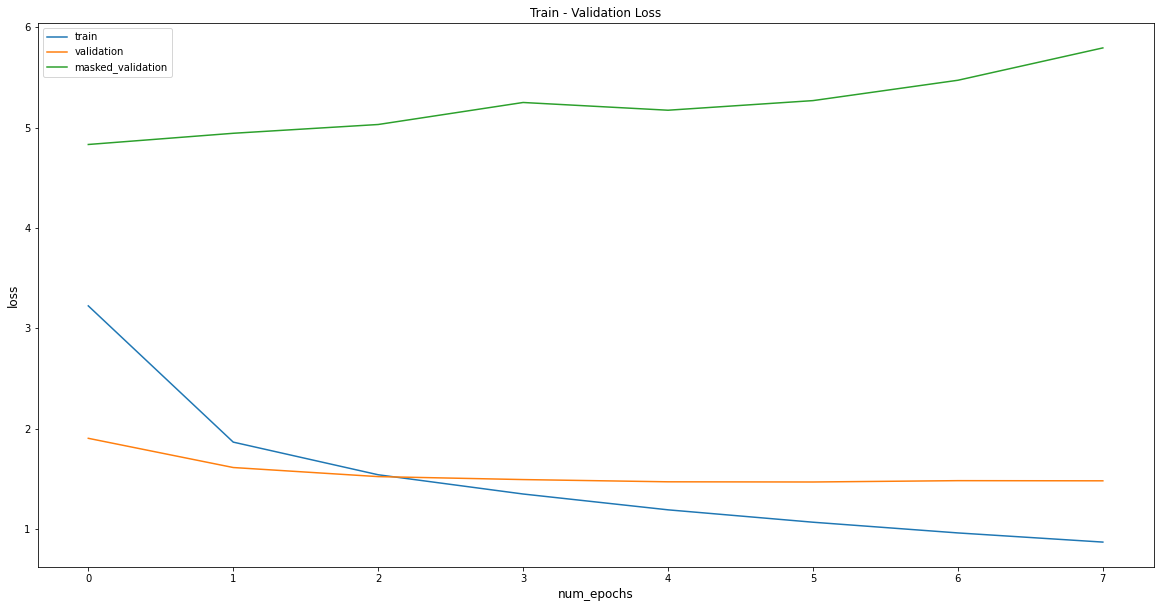

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.plot(masked_val_loss, label='masked_validation')

plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

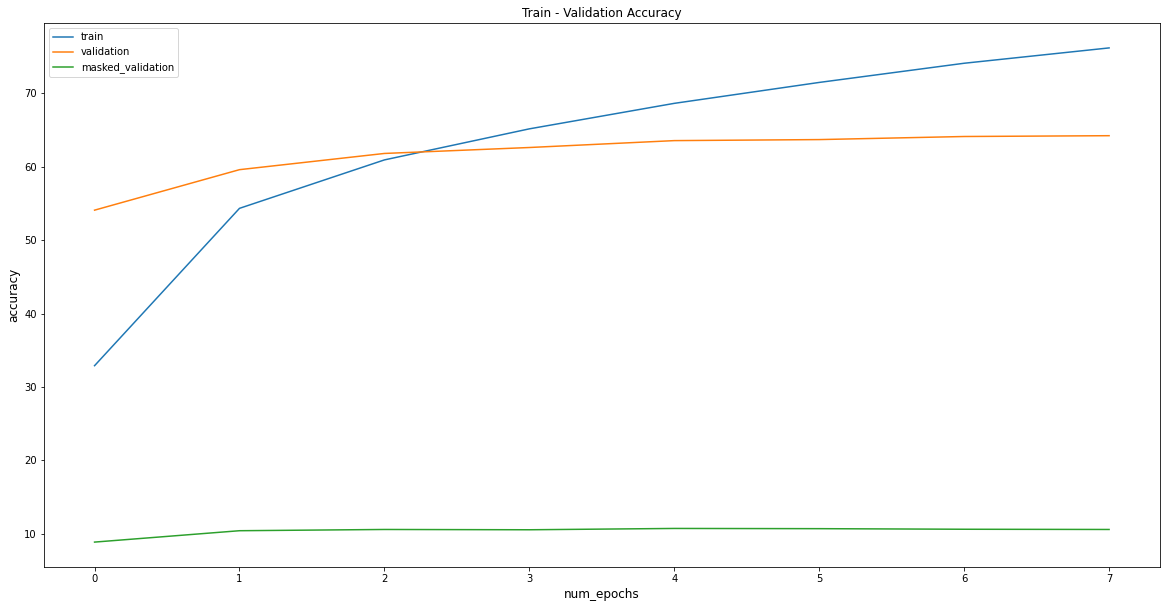

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.plot(masked_val_acc, label='masked_validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

Loaded pretrained weights for efficientnet-b3
validation loss: 6.9238, validation acc: 5.4450



In [ ]:
val_loss = []
val_acc = []
correct_t=0
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=200)

model = model.to(device)
model.load_state_dict(torch.load('model_classification_tutorial.pt'))

with torch.no_grad():
    model.eval()
    for data_t, target_t in (val_loader_pretrain):
        data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
        outputs_t = model(data_t)
        loss_t = criterion(outputs_t, target_t)
        batch_loss += loss_t.item()
        _,pred_t = torch.max(outputs_t, dim=1)
        correct_t += torch.sum(pred_t==target_t).item()
        total_t += target_t.size(0)
    val_acc.append(100 * correct_t / total_t)
    val_loss.append(batch_loss/len(val_loader_pretrain))
    print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')

Loaded pretrained weights for efficientnet-b3
validation loss: 8.4650, validation acc: 20.8700



[20.87]


In [ ]:
len(masked_val_loader_pretrain)

157

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')